In [1]:
import pandas as pd
import tensorflow as tf
from transformers import AutoTokenizer
import re
from transformers import DataCollatorForLanguageModeling
from transformers import AdamWeightDecay
from transformers import TFAutoModelForMaskedLM
from datasets import Dataset
import math
import numpy as np
import matplotlib.pyplot as plt
import torch

2023-11-24 09:08:51.882606: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-24 09:08:51.882629: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-24 09:08:51.882657: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-24 09:08:51.888047: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-24 09:08:52.398497: W tensorflow/compiler/

In [2]:
import tensorflow as tf
tf.config.experimental.list_physical_devices(device_type='GPU')

2023-11-24 09:08:54.250898: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-24 09:08:54.254586: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-24 09:08:54.254753: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
def json_to_dataframe(filename):
    f = open(filename)
    df = pd.read_json(f)
    print(df.iloc[0])
    f.close()
    df['news'] = df['news'].apply(lambda x: re.sub(r'\([^)]*\)', '', x)) # Remove time stamps
    df['masked headline'] = df['masked headline'].str.replace('____', '<mask> ') # Replace ___ with <mask>
    df['text'] = df[['news', 'masked headline', 'calculation']].apply(" ".join, axis=1)
    #df['text'] = df[['news', 'masked headline']].apply(" ".join, axis=1)
    df = df.astype(str)
    return df

In [4]:
df = json_to_dataframe('Train_Numerical_Reasoning.json')
df.head()

news               (Oct 7, 2014  12:40 PM CDT) As of Jan. 1, Walm...
masked headline    ____K Walmart Part-Timers to Lose Health Insur...
calculation                                     Paraphrase(30,000,K)
ans                                                               30
Name: 0, dtype: object


,news,masked headline,calculation,ans,text
0,"As of Jan. 1, Walmart will no longer offer 30...",<mask> K Walmart Part-Timers to Lose Health In...,"Paraphrase(30,000,K)",30,"As of Jan. 1, Walmart will no longer offer 30..."
1,Dax Shepard and Kristen Bell got married at t...,Dax Shepard: Wedding to Kristen Bell Cost $<ma...,Copy(142),142,Dax Shepard and Kristen Bell got married at t...
2,"Nancy Reagan, the helpmate, backstage adviser...",Nancy Reagan Dead at <mask>,Copy(94),94,"Nancy Reagan, the helpmate, backstage adviser..."
3,American Airlines faces FAA fines of more tha...,American Airlines Faces $<mask> M Fine for Saf...,Copy(7),7,American Airlines faces FAA fines of more tha...
4,"Ingrid Lyne, the Seattle mom allegedly murder...",$<mask> K Raised for Kids of Mom Dismembered o...,"Paraphrase(222,000,K)",222,"Ingrid Lyne, the Seattle mom allegedly murder..."


In [5]:
df.shape

(21157, 5)

In [6]:
dataset = Dataset.from_pandas(df)
dataset = dataset.train_test_split(test_size=0.2)

To load a DistilRoBERTa tokenizer to process the text for masked language modeling, 

RoBERTa  (short for “Robustly Optimized BERT Approach”) is a variant of the BERT (Bidirectional Encoder Representations from Transformers) model. Like BERT, RoBERTa is a transformer-based language model that uses self-attention to process input sequences and generate contextualized representations of words in a sentence. But RoBERTa was trained on more than 10 times larger than the dataset used to train BERT (160GB of text). Also RoBERTa uses a dynamic masking technique during training that helps the model learn more robust and generalizable representations of words. 

In [7]:
model_name = "distilroberta-base"

In [8]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [9]:
def preprocess_function(examples):
    inputs = tokenizer(examples['text'],truncation=True)
    inputs['labels'] = examples['ans']
    return inputs

To apply the preprocess function over the entire dataset

In [10]:
tokenized = dataset.map(preprocess_function, batched=True, num_proc=4,
                        remove_columns=dataset['train'].column_names)

Map (num_proc=4):   0%|          | 0/16925 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/4232 [00:00<?, ? examples/s]

In [11]:
tokenized['train']

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 16925
})

To create batches using DataCollatorForLanguageModeling, which dynamically pads the sentences to the longest length in a batch during collation. This is  more efficient than padding the whole dataset to the maximum length. To use the end-of-sequence token as the padding token and specify mlm_probability to randomly mask tokens each time iterated over the data.
Also, to set up optimizer function

In [14]:
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer,  mlm_probability=0.15,return_tensors="tf")
#optimizer = AdamWeightDecay(learning_rate=3e-5, weight_decay_rate=0.01)
optimizer = AdamWeightDecay(learning_rate=5e-5, weight_decay_rate=0.01)

To load DistilRoBERTa with AutoModelForMaskedLM

In [15]:
model = TFAutoModelForMaskedLM.from_pretrained(model_name)

2023-11-24 09:09:59.382068: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-24 09:09:59.382247: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-24 09:09:59.382382: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

To convert datasets to the tf.data.Dataset format 

In [16]:
tf_train_set = model.prepare_tf_dataset(
    tokenized["train"],
    shuffle=True,
    batch_size=6,
    collate_fn=data_collator,
)

tf_test_set = model.prepare_tf_dataset(
    tokenized["test"],
    shuffle=False,
    batch_size=6,
    collate_fn=data_collator,
)

You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [17]:
model.compile(optimizer=optimizer)

Perplexity to evaluate the model - to calculate the probabilities it assigns to the next word in all the sentences of the test set (the exponential of the cross-entropy loss is computed)

In [17]:
eval_loss = model.evaluate(tf_test_set)
print(f"Pretrained LM Perplexity: {math.exp(eval_loss):.2f}")

265/265 [==============================] - 39s 132ms/step - loss: 1.8290
Pretrained LM Perplexity: 6.23


In [18]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1)
history = model.fit(x=tf_train_set, validation_data=tf_test_set, callbacks=[callback],batch_size=3, epochs=15)

Epoch 1/15
2820/2820 [==============================] - 767s 270ms/step - loss: 1.5355 - val_loss: 1.3759
Epoch 2/15
2820/2820 [==============================] - 757s 268ms/step - loss: 1.4786 - val_loss: 1.3476
Epoch 3/15
2820/2820 [==============================] - 758s 269ms/step - loss: 1.4417 - val_loss: 1.3301
Epoch 4/15
2820/2820 [==============================] - 756s 268ms/step - loss: 1.4108 - val_loss: 1.3388


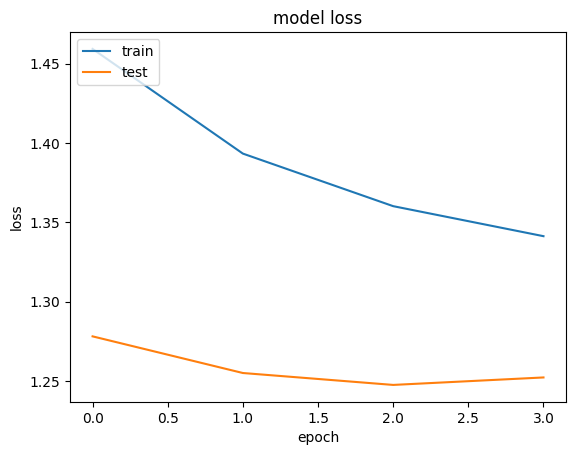

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [20]:
eval_loss = model.evaluate(tf_test_set)
print(f"Finetuned Perplexity: {math.exp(eval_loss):.2f}")

265/265 [==============================] - 35s 134ms/step - loss: 1.3041
Finetuned Perplexity: 3.68


To use the model for dev dataset

In [19]:
f = open('Dev_Numerical_Reasoning.json')
df = pd.read_json(f)
df['news'] = df['news'].apply(lambda x: re.sub(r'\([^)]*\)', '', x))
df['masked headline'] = df['masked headline'].str.replace('____', '<mask> ')    
df['text'] = df[['news', 'masked headline']].apply(" ".join, axis=1)
df = df.astype(str)
#df = df.iloc[100:100]
f.close()
test_data = Dataset.from_pandas(df)

In [20]:
def predictions(data, tokenizer, model):
    inputs = tokenizer(data['text'], return_tensors="np")
    logits = model(**inputs).logits
    mask_token_index = np.argwhere(inputs["input_ids"] == tokenizer.mask_token_id)[0, 1]
    mask_token_logits = logits[0, mask_token_index, :]
    top_tokens = tf.math.top_k(mask_token_logits, 20).indices.numpy()
    result = ''

    for token in top_tokens:
        result = tokenizer.decode([token][0]).strip()
        if result.isnumeric():
            break
        else:
            continue

    return result

In [21]:
tr = 0
pre = []
for i in test_data:
    prediction = predictions(i, tokenizer, model)
    pre.append(prediction)
    ans = i['ans']
    print("Prediction: ", prediction)
    print("Answer:     ", i['ans'])
    print("Calc: ", i['calculation'])
    if prediction == ans:
        tr += 1
    print("")

Prediction:  3
Answer:      3
Calc:  Trans(three)

Prediction:  161
Answer:      12
Calc:  Copy(12)

Prediction:  305
Answer:      305
Calc:  Round(305.45,0)

Prediction:  1
Answer:      1
Calc:  Copy(1)

Prediction:  10
Answer:      10
Calc:  Copy(10)

Prediction:  1959
Answer:      1959
Calc:  Copy(1959)

Prediction:  218
Answer:      218
Calc:  Copy(218)

Prediction:  5
Answer:      9
Calc:  Round(Divide(268,30),0)

Prediction:  2
Answer:      2
Calc:  Paraphrase(2,000,K)

Prediction:  60
Answer:      60
Calc:  Copy(60)

Prediction:  25
Answer:      25
Calc:  Copy(25)

Prediction:  6
Answer:      6
Calc:  Copy(6)

Prediction:  1
Answer:      1
Calc:  Round(1.29,0)

Prediction:  4
Answer:      4
Calc:  Copy(4)

Prediction:  3
Answer:      3
Calc:  Trans(third)

Prediction:  30
Answer:      30
Calc:  Copy(30)

Prediction:  20
Answer:      20
Calc:  Copy(20)

Prediction:  5
Answer:      5
Calc:  Trans(five)

Prediction:  55
Answer:      55
Calc:  Copy(55)

Prediction:  65
Answer:      

Prediction:  13
Answer:      13
Calc:  Copy(13)

Prediction:  3
Answer:      3.2
Calc:  Copy(3.2)

Prediction:  3
Answer:      3
Calc:  Round(Paraphrase(3,175,K),0)

Prediction:  92
Answer:      92
Calc:  Copy(92)

Prediction:  8
Answer:      8
Calc:  Copy(8)

Prediction:  50
Answer:      50
Calc:  Copy(50)

Prediction:  23
Answer:      23
Calc:  Copy(23)

Prediction:  50
Answer:      50
Calc:  Copy(50)

Prediction:  5
Answer:      2
Calc:  Trans(two)

Prediction:  30
Answer:      30
Calc:  Copy(30)

Prediction:  4
Answer:      2
Calc:  Add(Span(Old America),Span(New America))

Prediction:  77
Answer:      77
Calc:  Copy(77)

Prediction:  10
Answer:      10
Calc:  Copy(10)

Prediction:  10
Answer:      15.5
Calc:  Add(10,5.5)

Prediction:  4
Answer:      4
Calc:  Trans(four)

Prediction:  250
Answer:      250
Calc:  Copy(250)

Prediction:  86
Answer:      86
Calc:  Copy(86)

Prediction:  100
Answer:      100
Calc:  Subtract(109,9)

Prediction:  1
Answer:      1
Calc:  Copy(1)

Predicti

Prediction:  40
Answer:      9/11
Calc:  Trans(Sept. 11)

Prediction:  75
Answer:      75
Calc:  Copy(75)

Prediction:  60
Answer:      60
Calc:  Paraphrase(60,000,K)

Prediction:  2016
Answer:      2016
Calc:  Copy(2016)

Prediction:  60
Answer:      60
Calc:  Copy(60)

Prediction:  1
Answer:      1
Calc:  Copy(1)

Prediction:  88
Answer:      88
Calc:  Copy(88)

Prediction:  2
Answer:      2
Calc:  Copy(2)

Prediction:  12
Answer:      12
Calc:  Trans(Twelve)

Prediction:  7
Answer:      7
Calc:  Trans(seven)

Prediction:  2012
Answer:      2012
Calc:  Copy(2012)

Prediction:  200
Answer:      20
Calc:  Paraphrase(20,000,K)

Prediction:  1
Answer:      1.2
Calc:  Copy(1.2)

Prediction:  40
Answer:      40
Calc:  Copy(40)

Prediction:  500
Answer:      1,000
Calc:  Copy(1,000)

Prediction:  85
Answer:      85
Calc:  Copy(85)

Prediction:  2
Answer:      2
Calc:  Trans(two)

Prediction:  85
Answer:      85
Calc:  Copy(85)

Prediction:  2010
Answer:      2010
Calc:  Copy(2010)

Predicti

Prediction:  1
Answer:      1
Calc:  Copy(1)

Prediction:  2015
Answer:      2015
Calc:  Copy(2015)

Prediction:  9
Answer:      9.8
Calc:  Paraphrase(9,800,K)

Prediction:  6
Answer:      6
Calc:  Trans(six)

Prediction:  41
Answer:      1
Calc:  Trans(first)

Prediction:  5
Answer:      5
Calc:  Trans(five)

Prediction:  200
Answer:      1,200
Calc:  Copy(1,200)

Prediction:  15
Answer:      15
Calc:  Copy(15)

Prediction:  66
Answer:      66
Calc:  Copy(66)

Prediction:  2
Answer:      2
Calc:  Copy(2)

Prediction:  7
Answer:      7
Calc:  Copy(7)

Prediction:  28
Answer:      73
Calc:  Add(28,45)

Prediction:  10
Answer:      10
Calc:  Paraphrase(10,000,K)

Prediction:  3
Answer:      3
Calc:  Trans(three)

Prediction:  10
Answer:      11
Calc:  Copy(11)

Prediction:  27
Answer:      27.2
Calc:  Round(Multiply(Divide(Subtract(5.26,3.83),5.26),100),1)

Prediction:  100
Answer:      100
Calc:  Copy(100)

Prediction:  10
Answer:      10
Calc:  Copy(10)

Prediction:  2
Answer:      2
C

Prediction:  1
Answer:      1.2
Calc:  Copy(1.2)

Prediction:  250
Answer:      250
Calc:  Copy(250)

Prediction:  2
Answer:      2
Calc:  Trans(second)

Prediction:  25
Answer:      25
Calc:  Paraphrase(25,000,K)

Prediction:  5
Answer:      32
Calc:  Trans(Thirty-two)

Prediction:  2
Answer:      2
Calc:  Trans(two)

Prediction:  9
Answer:      9
Calc:  Trans(nine)

Prediction:  2
Answer:      2
Calc:  Paraphrase(2,000,K)

Prediction:  3
Answer:      3.4
Calc:  Copy(3.4)

Prediction:  New
Answer:      1906
Calc:  Copy(1906)

Prediction:  3
Answer:      2
Calc:  Trans(two)

Prediction:  2
Answer:      2
Calc:  Trans(two)

Prediction:  8
Answer:      8
Calc:  Copy(8)

Prediction:  3
Answer:      1.3
Calc:  Paraphrase(1,300,K)

Prediction:  81
Answer:      81
Calc:  Copy(81)

Prediction:  1
Answer:      1
Calc:  Trans(first)

Prediction:  8
Answer:      8
Calc:  Copy(8)

Prediction:  11
Answer:      192
Calc:  Copy(192)

Prediction:  300
Answer:      20
Calc:  Copy(20)

Prediction:  100

Prediction:  200
Answer:      200
Calc:  Copy(200)

Prediction:  10
Answer:      10
Calc:  Copy(10)

Prediction:  107
Answer:      107
Calc:  Copy(107)

Prediction:  5
Answer:      5
Calc:  Trans(Five)

Prediction:  53
Answer:      53
Calc:  Copy(53)

Prediction:  2
Answer:      2
Calc:  Trans(Two)

Prediction:  2
Answer:      2
Calc:  Trans(two)

Prediction:  25
Answer:      25
Calc:  Copy(25)

Prediction:  7
Answer:      7
Calc:  Copy(7)

Prediction:  248
Answer:      248
Calc:  Copy(248)

Prediction:  35
Answer:      35
Calc:  Copy(35)

Prediction:  900
Answer:      900
Calc:  Copy(900)

Prediction:  100
Answer:      100
Calc:  Copy(100)

Prediction:  10
Answer:      11
Calc:  Round(10.9,0)

Prediction:  4
Answer:      4
Calc:  Copy(4)

Prediction:  2
Answer:      2
Calc:  Trans(two)

Prediction:  10
Answer:      10
Calc:  Copy(10)

Prediction:  60
Answer:      60
Calc:  Copy(60)

Prediction:  20
Answer:      20
Calc:  Copy(20)

Prediction:  13
Answer:      13
Calc:  Copy(13)

Predi

Prediction:  4
Answer:      4
Calc:  Copy(4)

Prediction:  36
Answer:      36
Calc:  Copy(36)

Prediction:  70
Answer:      70
Calc:  Copy(70)

Prediction:  97
Answer:      97
Calc:  Copy(97)

Prediction:  2020
Answer:      2020
Calc:  Copy(2020)

Prediction:  340
Answer:      340
Calc:  Paraphrase(340,000,K)

Prediction:  53
Answer:      53
Calc:  Copy(53)

Prediction:  9
Answer:      9
Calc:  Copy(9)

Prediction:  13
Answer:      13
Calc:  Copy(13)

Prediction:  2
Answer:      2
Calc:  Trans(two)

Prediction:  13
Answer:      2.5
Calc:  Copy(2.5)

Prediction:  09
Answer:      09
Calc:  Subtract(2009,2000)

Prediction:  2
Answer:      40
Calc:  Copy(40)

Prediction:  22
Answer:      22
Calc:  Copy(22)

Prediction:  2050
Answer:      2050
Calc:  Copy(2050)

Prediction:  7
Answer:      7
Calc:  Copy(7)

Prediction:  390
Answer:      390
Calc:  Paraphrase(390,000,K)

Prediction:  800
Answer:      800
Calc:  Copy(800)

Prediction:  5
Answer:      5.2
Calc:  Copy(5.2)

Prediction:  10
Answ

Prediction:  8
Answer:      8
Calc:  Trans(eighth)

Prediction:  3
Answer:      3
Calc:  Trans(three)

Prediction:  38
Answer:      35
Calc:  Copy(35)

Prediction:  69
Answer:      70,000
Calc:  Copy(70,000)

Prediction:  2
Answer:      2.5
Calc:  Copy(2.5)

Prediction:  4
Answer:      4
Calc:  Copy(4)

Prediction:  24
Answer:      24
Calc:  Copy(24)

Prediction:  550
Answer:      550
Calc:  Copy(550)

Prediction:  3
Answer:      3
Calc:  Copy(3)

Prediction:  2
Answer:      2
Calc:  Trans(Two)

Prediction:  90
Answer:      91
Calc:  Subtract(1991,1900)

Prediction:  3
Answer:      3
Calc:  Trans(three)

Prediction:  3
Answer:      3
Calc:  Round(3.12,0)

Prediction:  13
Answer:      13
Calc:  Copy(13)

Prediction:  08
Answer:      08
Calc:  Subtract(2008,2000)

Prediction:  30
Answer:      30
Calc:  Copy(30)

Prediction:  7
Answer:      7
Calc:  Trans(seven)

Prediction:  2
Answer:      2
Calc:  Trans(second)

Prediction:  45
Answer:      45
Calc:  Copy(45)

Prediction:  2018
Answer: 

Prediction:  10
Answer:      10
Calc:  Copy(10)

Prediction:  99
Answer:      99
Calc:  Copy(99)

Prediction:  10
Answer:      10
Calc:  Copy(10)

Prediction:  2
Answer:      2
Calc:  Copy(2)

Prediction:  2025
Answer:      2035
Calc:  Copy(2035)

Prediction:  45
Answer:      45
Calc:  Copy(45)

Prediction:  73
Answer:      73
Calc:  Copy(73)

Prediction:  3
Answer:      3
Calc:  Trans(three)

Prediction:  2005
Answer:      2005
Calc:  Copy(2005)

Prediction:  7
Answer:      7
Calc:  Copy(7)

Prediction:  6
Answer:      6
Calc:  Trans(six)

Prediction:  3
Answer:      3.6
Calc:  Copy(3.6)

Prediction:  10
Answer:      10
Calc:  Copy(10)

Prediction:  10
Answer:      09
Calc:  Subtract(2009,2000)

Prediction:  3
Answer:      3
Calc:  Copy(3)

Prediction:  10
Answer:      10
Calc:  Copy(10)

Prediction:  53
Answer:      53
Calc:  Copy(53)

Prediction:  108
Answer:      108
Calc:  Copy(108)

Prediction:  7
Answer:      7
Calc:  Paraphrase(7,000,K)

Prediction:  3
Answer:      3
Calc:  Tra

Prediction:  32
Answer:      32
Calc:  Copy(32)

Prediction:  5
Answer:      5
Calc:  Copy(5)

Prediction:  8
Answer:      8
Calc:  Copy(8)

Prediction:  3
Answer:      3
Calc:  Copy(3)

Prediction:  10
Answer:      12
Calc:  Subtract(2025,2013)

Prediction:  51
Answer:      51
Calc:  Copy(51)

Prediction:  22
Answer:      22.5
Calc:  Copy(22.5)

Prediction:  1936
Answer:      1936
Calc:  Copy(1936)

Prediction:  6
Answer:      6
Calc:  Copy(6)

Prediction:  2012
Answer:      2012
Calc:  Copy(2012)

Prediction:  10
Answer:      10
Calc:  Copy(10)

Prediction:  10
Answer:      40
Calc:  Copy(40)

Prediction:  4
Answer:      4
Calc:  Trans(four)

Prediction:  3
Answer:      143
Calc:  Copy(143)

Prediction:  5
Answer:      5
Calc:  Copy(5)

Prediction:  20
Answer:      20
Calc:  Copy(20)

Prediction:  7
Answer:      7
Calc:  Copy(7)

Prediction:  10
Answer:      10
Calc:  Copy(10)

Prediction:  2
Answer:      2
Calc:  Copy(2)

Prediction:  2
Answer:      30
Calc:  Add(Subtract(30,10),8)


Prediction:  600
Answer:      600
Calc:  Copy(600)

Prediction:  61
Answer:      61
Calc:  Subtract(1961,1900)

Prediction:  1
Answer:      1
Calc:  Copy(1)

Prediction:  3
Answer:      4
Calc:  Trans(four)

Prediction:  5
Answer:      5
Calc:  Copy(5)

Prediction:  1
Answer:      1
Calc:  Copy(1)

Prediction:  3
Answer:      3
Calc:  Copy(3)

Prediction:  1
Answer:      1
Calc:  Copy(1)

Prediction:  3
Answer:      7
Calc:  Copy(7)

Prediction:  20
Answer:      20
Calc:  Copy(20)

Prediction:  230
Answer:      230
Calc:  Paraphrase(230,000,K)

Prediction:  6
Answer:      6
Calc:  Trans(Six)

Prediction:  200
Answer:      200
Calc:  Copy(200)

Prediction:  10
Answer:      7
Calc:  Copy(7)

Prediction:  47
Answer:      47
Calc:  Round(Paraphrase(47,400 ,K),0)

Prediction:  3
Answer:      3
Calc:  Trans(third)

Prediction:  2
Answer:      2
Calc:  Copy(2)

Prediction:  1
Answer:      1
Calc:  Trans(first)

Prediction:  14
Answer:      14
Calc:  Copy(14)

Prediction:  230
Answer:      230

Prediction:  50
Answer:      50
Calc:  Paraphrase(50,000 ,K)

Prediction:  3
Answer:      33
Calc:  Copy(33)

Prediction:  2
Answer:      2.13
Calc:  Copy(2.13)

Prediction:  2
Answer:      2
Calc:  Trans(Two)

Prediction:  10
Answer:      10
Calc:  Paraphrase(10,000,K)

Prediction:  8
Answer:      8
Calc:  Copy(8)

Prediction:  450
Answer:      13.2
Calc:  Copy(13.2)

Prediction:  64
Answer:      64
Calc:  Copy(64)

Prediction:  29
Answer:      29
Calc:  Copy(29)

Prediction:  8
Answer:      8
Calc:  Copy(8)

Prediction:  Free
Answer:      9/11
Calc:  Copy(9/11)

Prediction:  14
Answer:      14
Calc:  Copy(14)

Prediction:  3
Answer:      3
Calc:  Trans(three)

Prediction:  8
Answer:      8
Calc:  Copy(8)

Prediction:  8
Answer:      8
Calc:  Copy(8)

Prediction:  2
Answer:      2
Calc:  Trans(four)

Prediction:  90
Answer:      90
Calc:  Copy(90)

Prediction:  30
Answer:      30
Calc:  Copy(30)

Prediction:  16
Answer:      16
Calc:  Subtract(2016,2000)

Prediction:  173
Answer:     

Prediction:  181
Answer:      181
Calc:  Copy(181)

Prediction:  2
Answer:      2
Calc:  Copy(2)

Prediction:  42
Answer:      42
Calc:  Copy(42)

Prediction:  10
Answer:      10
Calc:  Copy(10)

Prediction:  11
Answer:      11
Calc:  Copy(11)

Prediction:  1980
Answer:      1980
Calc:  Copy(1980)

Prediction:  9
Answer:      7
Calc:  Trans(seven)

Prediction:  9
Answer:      9
Calc:  Copy(9)

Prediction:  22
Answer:      22
Calc:  Copy(22)

Prediction:  70
Answer:      70
Calc:  Copy(70)

Prediction:  20
Answer:      20
Calc:  Copy(20)

Prediction:  2
Answer:      2.2
Calc:  Copy(2.2)

Prediction:  5
Answer:      5
Calc:  Round(Paraphrase(5,100,K),0)

Prediction:  19
Answer:      19
Calc:  Copy(19)

Prediction:  8
Answer:      8
Calc:  Copy(8)

Prediction:  2001
Answer:      2001
Calc:  Copy(2001)

Prediction:  7
Answer:      7
Calc:  Trans(seven)

Prediction:  2
Answer:      2
Calc:  Copy(2)

Prediction:  10
Answer:      10
Calc:  Copy(10)

Prediction:  1
Answer:      30
Calc:  Copy(

Prediction:  4
Answer:      4
Calc:  Copy(4)

Prediction:  125
Answer:      125
Calc:  Paraphrase(125,000,K)

Prediction:  1
Answer:      1
Calc:  Trans(one)

Prediction:  1
Answer:      2020
Calc:  Copy(2020)

Prediction:  1
Answer:      1,000
Calc:  Copy(1,000)

Prediction:  2
Answer:      2
Calc:  Trans(two)

Prediction:  3
Answer:      3
Calc:  Copy(3)

Prediction:  11
Answer:      11
Calc:  Copy(11)

Prediction:  12
Answer:      12
Calc:  Copy(12)

Prediction:  24
Answer:      24
Calc:  Copy(24)

Prediction:  8
Answer:      8
Calc:  Copy(8)

Prediction:  9
Answer:      9
Calc:  Trans(Nine)

Prediction:  78
Answer:      9
Calc:  Trans(nine)

Prediction:  234
Answer:      230
Calc:  Paraphrase(230,000,K)

Prediction:  3
Answer:      3.5
Calc:  Round(Paraphrase(3,497,K),1)

Prediction:  7
Answer:      7
Calc:  Copy(7)

Prediction:  9
Answer:      9
Calc:  Trans(nine)

Prediction:  3
Answer:      3
Calc:  Copy(3)

Prediction:  2017
Answer:      2020
Calc:  Copy(2020)

Prediction:  201

Prediction:  40
Answer:      40
Calc:  Copy(40)

Prediction:  1
Answer:      1
Calc:  Paraphrase(1,000,K)

Prediction:  9
Answer:      9
Calc:  Copy(9)

Prediction:  4
Answer:      4
Calc:  Trans(Four)

Prediction:  6
Answer:      6.7
Calc:  Copy(6.7)

Prediction:  30
Answer:      2
Calc:  Copy(2)

Prediction:  60
Answer:      60
Calc:  Copy(60)

Prediction:  2
Answer:      2
Calc:  Copy(2)

Prediction:  5
Answer:      5
Calc:  Trans(five)

Prediction:  10
Answer:      10
Calc:  Copy(10)

Prediction:  22
Answer:      22
Calc:  Copy(22)

Prediction:  46
Answer:      46
Calc:  Copy(46)

Prediction:  11
Answer:      11
Calc:  Paraphrase(110,000,K)

Prediction:  1
Answer:      1
Calc:  Copy(1)

Prediction:  53
Answer:      53
Calc:  Copy(53)

Prediction:  83
Answer:      83
Calc:  Copy(83)

Prediction:  5
Answer:      5
Calc:  Trans(five)

Prediction:  9
Answer:      9
Calc:  Copy(9)

Prediction:  9
Answer:      9
Calc:  Copy(9)

Prediction:  80
Answer:      80
Calc:  Copy(80)

Prediction:

Prediction:  69
Answer:      69
Calc:  Copy(69)

Prediction:  2018
Answer:      2018
Calc:  Copy(2018)

Prediction:  7
Answer:      7
Calc:  Trans(seven)

Prediction:  74
Answer:      74
Calc:  Copy(74)

Prediction:  500
Answer:      500
Calc:  Copy(500)

Prediction:  4
Answer:      5
Calc:  Trans(five)

Prediction:  4
Answer:      4
Calc:  Copy(4)

Prediction:  3
Answer:      2
Calc:  Trans(two)

Prediction:  860
Answer:      860
Calc:  Paraphrase(860,000,K)

Prediction:  5
Answer:      5
Calc:  Trans(Five)

Prediction:  45
Answer:      45
Calc:  Copy(45)

Prediction:  21
Answer:      21
Calc:  Copy(21)

Prediction:  2
Answer:      22
Calc:  Paraphrase(22,000,K)

Prediction:  16
Answer:      16
Calc:  Copy(16)

Prediction:  20
Answer:      300
Calc:  Paraphrase(300,000,K)

Prediction:  10
Answer:      10
Calc:  Copy(10)

Prediction:  330
Answer:      330
Calc:  Copy(330)

Prediction:  8
Answer:      8
Calc:  Trans(Eight)

Prediction:  2017
Answer:      2016
Calc:  Copy(2016)

Predicti

Prediction:  3
Answer:      3
Calc:  Trans(three)

Prediction:  3
Answer:      3
Calc:  Trans(three)



In [22]:
tr/len(test_data)

0.7982115085536547

In [23]:
from sklearn.metrics import accuracy_score
accuracy_score(df['ans'], pre)

0.7982115085536547